# MENACE + Multi-Armed Bandit Problems

This notebook implements:
1. MENACE (Matchbox Educable Naughts and Crosses Engine) - A Tic-Tac-Toe reinforcement learning agent
2. Binary Bandit Problem with epsilon-greedy algorithm
3. 10-armed non-stationary bandit with modified epsilon-greedy tracking

## Setup and Imports

In [50]:

import json
import random
import pickle
from collections import defaultdict
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np

## Part 1: MENACE Implementation

### MENACE Class Definition

The MENACE (Matchbox Educable Naughts and Crosses Engine) is a reinforcement learning agent that learns to play Tic-Tac-Toe using a simple bead-based mechanism. Each game state has a "matchbox" containing beads representing different moves, and the probability of choosing a move is proportional to its bead count.

**Key Features:**
- **Matchboxes**: Dictionary storing bead counts for each state
- **Learning mechanism**: Adds beads for wins/draws, removes for losses
- **State representation**: 9-position board converted to string keys

In [51]:
class MenaceAgent:
    def __init__(self, initial_beads: int = 10):
        self.matchboxes: Dict[str, List[int]] = {}
        self.initial_beads = int(initial_beads)
        self.game_history: List[Tuple[str, int]] = []

    @staticmethod
    def state_key(board: List[int]) -> str:
        """Convert board (list of 9 ints) to string key."""
        return ''.join(str(int(x)) for x in board)

    def valid_moves(self, board: List[int]) -> List[int]:
        return [i for i, v in enumerate(board) if int(v) == 0]

    def init_matchbox(self, board: List[int]) -> None:
        key = self.state_key(board)
        if key not in self.matchboxes:
            beads = [self.initial_beads if board[i] == 0 else 0 for i in range(9)]
            self.matchboxes[key] = beads

    def select_move(self, board: List[int]) -> int:
        key = self.state_key(board)
        self.init_matchbox(board)
        beads = self.matchboxes[key]
        valid_moves = self.valid_moves(board)
        if not valid_moves:
            raise ValueError("No valid moves available")

        total = sum(beads[i] for i in valid_moves)
        if total <= 0:
            move = random.choice(valid_moves)
        else:
            weights = [beads[i] for i in valid_moves]
            # random.choices expects sequences; return the chosen move index
            move = random.choices(valid_moves, weights=weights, k=1)[0]

        self.game_history.append((key, move))
        return move

    def learn(self, reward: int) -> None:
        for key, move in self.game_history:
            if key not in self.matchboxes:
                continue
            if reward > 0:
                self.matchboxes[key][move] += 3
            elif reward == 0:
                self.matchboxes[key][move] += 1
            else:
                self.matchboxes[key][move] = max(0, self.matchboxes[key][move] - 1)
        self.game_history = []

    def clear_history(self) -> None:
        self.game_history = []

    # Persistence helpers
    def save_matchboxes(self, filename: str) -> None:
        with open(filename, "wb") as f:
            pickle.dump({
                "initial_beads": self.initial_beads,
                "matchboxes": self.matchboxes
            }, f)

    @classmethod
    def load_matchboxes(cls, filename: str) -> "MenaceAgent":
        with open(filename, "rb") as f:
            data = pickle.load(f)
        agent = cls(initial_beads=data.get("initial_beads", 10))
        agent.matchboxes = data.get("matchboxes", {})
        return agent

### Tic-Tac-Toe Game Utilities

Helper functions for checking winners and implementing a random opponent.

In [52]:
WINNING_LINES = [
    (0, 1, 2),
    (3, 4, 5),
    (6, 7, 8),
    (0, 3, 6),
    (1, 4, 7),
    (2, 5, 8),
    (0, 4, 8),
    (2, 4, 6)
]

def evaluate_winner(board: List[int]) -> int:
    """Return 0 if no winner yet, 1 if player 1 wins, 2 if player 2 wins, -1 if draw."""
    for a, b, c in WINNING_LINES:
        if board[a] != 0 and board[a] == board[b] == board[c]:
            return int(board[a])
    if all(x != 0 for x in board):
        return -1  # draw
    return 0  # game continues

def random_move(board: List[int], player: int) -> int:
    valid = [i for i, v in enumerate(board) if v == 0]
    move = random.choice(valid)
    board[move] = player
    return move

### Training and Evaluation Functions

Functions to train MENACE against a random opponent and evaluate its performance.

In [53]:
def train_menace_agent(num_episodes: int = 20000,
                       initial_beads: int = 10,
                       verbose_every: int = 2000,
                       seed: int = 0) -> Tuple[MenaceAgent, Dict[str, float]]:
    random.seed(seed)
    np.random.seed(seed)

    menace_agent = MenaceAgent(initial_beads=initial_beads)
    stats = {"win": 0, "draw": 0, "loss": 0}

    for ep in range(1, num_episodes + 1):
        board = [0] * 9
        menace_agent.clear_history()
        # randomly decide who starts
        is_menace_turn = random.random() < 0.5

        # Play until game ends
        while True:
            if is_menace_turn:
                # MENACE move
                move = menace_agent.select_move(board)
                board[move] = 1
            else:
                # Random opponent move
                random_move(board, player=2)

            result = evaluate_winner(board)
            if result != 0:
                # Game ended
                if result == 1:
                    stats["win"] += 1
                    menace_agent.learn(1)
                elif result == 2:
                    stats["loss"] += 1
                    menace_agent.learn(-1)
                else:  # draw
                    stats["draw"] += 1
                    menace_agent.learn(0)
                break

            # switch turn
            is_menace_turn = not is_menace_turn

        if verbose_every and ep % verbose_every == 0:
            total = ep
            w, d, l = stats["win"], stats["draw"], stats["loss"]
            print(f"[Train] Episodes: {ep:6d}  Win: {w}  Draw: {d}  Loss: {l}  Win%: {w/total:.3f}")

    total = num_episodes
    stats_summary = {
        "episodes": total,
        "win_pct": stats["win"] / total,
        "draw_pct": stats["draw"] / total,
        "loss_pct": stats["loss"] / total,
    }
    return menace_agent, stats_summary

def evaluate_menace_agent(menace_agent: MenaceAgent, num_games: int = 2000, seed: int = 1) -> Dict[str, float]:
    random.seed(seed)
    np.random.seed(seed+1)
    stats = {"win": 0, "draw": 0, "loss": 0}

    for _ in range(num_games):
        board = [0] * 9
        menace_agent.clear_history()
        is_menace_turn = random.random() < 0.5

        while True:
            if is_menace_turn:
                move = menace_agent.select_move(board)
                board[move] = 1
            else:
                random_move(board, player=2)
            result = evaluate_winner(board)
            if result != 0:
                if result == 1:
                    stats["win"] += 1
                    menace_agent.learn(1)
                elif result == 2:
                    stats["loss"] += 1
                    menace_agent.learn(-1)
                else:
                    stats["draw"] += 1
                    menace_agent.learn(0)
                break
            is_menace_turn = not is_menace_turn

    total = num_games
    return {
        "games": total,
        "win_pct": stats["win"] / total,
        "draw_pct": stats["draw"] / total,
        "loss_pct": stats["loss"] / total
    }

### Train and Evaluate MENACE

Execute the training and evaluation process.

In [54]:
# Train MENACE
print("Training MENACE vs Random opponent...")
menace_agent, train_stats = train_menace_agent(num_episodes=20000, initial_beads=10, verbose_every=5000, seed=42)
print("Training complete.")
print(f"Train summary: Episodes={train_stats['episodes']}, Win%={train_stats['win_pct']:.3f}, "
      f"Draw%={train_stats['draw_pct']:.3f}, Loss%={train_stats['loss_pct']:.3f}")

# Save learned matchboxes
menace_agent.save_matchboxes("menace_matchboxes.pkl")
print("Saved MENACE matchboxes to 'menace_matchboxes.pkl'")

# Evaluate MENACE
print("\nEvaluating MENACE for 2000 games...")
eval_stats = evaluate_menace_agent(menace_agent, num_games=2000, seed=123)
print(f"Eval summary: Games={eval_stats['games']}, Win%={eval_stats['win_pct']:.3f}, "
      f"Draw%={eval_stats['draw_pct']:.3f}, Loss%={eval_stats['loss_pct']:.3f}")

Training MENACE vs Random opponent...
[Train] Episodes:   5000  Win: 2250  Draw: 664  Loss: 2086  Win%: 0.450
[Train] Episodes:  10000  Win: 4740  Draw: 1306  Loss: 3954  Win%: 0.474
[Train] Episodes:  10000  Win: 4740  Draw: 1306  Loss: 3954  Win%: 0.474
[Train] Episodes:  15000  Win: 7425  Draw: 1960  Loss: 5615  Win%: 0.495
[Train] Episodes:  15000  Win: 7425  Draw: 1960  Loss: 5615  Win%: 0.495
[Train] Episodes:  20000  Win: 10225  Draw: 2571  Loss: 7204  Win%: 0.511
Training complete.
Train summary: Episodes=20000, Win%=0.511, Draw%=0.129, Loss%=0.360
Saved MENACE matchboxes to 'menace_matchboxes.pkl'

Evaluating MENACE for 2000 games...
Eval summary: Games=2000, Win%=0.611, Draw%=0.107, Loss%=0.282
[Train] Episodes:  20000  Win: 10225  Draw: 2571  Loss: 7204  Win%: 0.511
Training complete.
Train summary: Episodes=20000, Win%=0.511, Draw%=0.129, Loss%=0.360
Saved MENACE matchboxes to 'menace_matchboxes.pkl'

Evaluating MENACE for 2000 games...
Eval summary: Games=2000, Win%=0.611,

## Part 2: Binary Bandit Problem

### Binary Bandit Class and Epsilon-Greedy Algorithm

Implementation of a binary bandit (two arms with stochastic rewards) and the epsilon-greedy strategy for balancing exploration and exploitation.

**Key Concepts:**
- **Epsilon-greedy**: With probability ε, explore randomly; otherwise, exploit best action
- **Q-value updates**: Use incremental mean to update action values
- **Stochastic rewards**: Each arm returns 1 (success) or 0 (failure) probabilistically

In [55]:
class BernoulliBandit:
    def __init__(self, prob_success: float):
        self.prob = float(prob_success)

    def pull(self) -> int:
        return 1 if np.random.random() < self.prob else 0

def epsilon_greedy_two_arm(bandit_a: BernoulliBandit,
                         bandit_b: BernoulliBandit,
                         epsilon: float = 0.1,
                         n_steps: int = 10000,
                         seed: int = 0):
    np.random.seed(seed)
    random.seed(seed)
    q_values = np.zeros(2)
    counts = np.zeros(2)
    rewards = np.empty(n_steps)
    actions = np.empty(n_steps, dtype=int)
    q_values_history = [q_values.copy()]

    for t in range(n_steps):
        if np.random.random() < epsilon:
            action = np.random.randint(2)
        else:
            action = int(np.argmax(q_values))
        reward = bandit_a.pull() if action == 0 else bandit_b.pull()
        counts[action] += 1
        q_values[action] += (reward - q_values[action]) / counts[action]
        rewards[t] = reward
        actions[t] = action
        q_values_history.append(q_values.copy())

    return rewards, actions, np.vstack(q_values_history)

### Plotting Function for Binary Bandit

Visualization showing cumulative rewards, Q-value convergence, and action selection distribution.

In [56]:
def plot_binary_results(rewards, actions, q_history, true_probs):
    fig, axes = plt.subplots(3, 1, figsize=(12, 11))
    fig.patch.set_facecolor('#f8f9fa')
    
    # Plot 1: Cumulative Reward with gradient effect
    axes[0].plot(np.cumsum(rewards), color='#2E86AB', linewidth=2.5, alpha=0.9)
    axes[0].fill_between(range(len(rewards)), 0, np.cumsum(rewards), alpha=0.2, color='#2E86AB')
    axes[0].set_title("Cumulative Reward Over Time", fontsize=14, fontweight='bold', pad=15)
    axes[0].set_xlabel("Time Step", fontsize=11)
    axes[0].set_ylabel("Cumulative Reward", fontsize=11)
    axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    axes[0].set_facecolor('#ffffff')
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # Plot 2: Q-value estimates with different styling
    axes[1].plot(q_history[:, 0], label=f"Bandit A (True: {true_probs[0]:.2f})", 
                 color='#A23B72', linewidth=2.2, linestyle='-', alpha=0.85)
    axes[1].plot(q_history[:, 1], label=f"Bandit B (True: {true_probs[1]:.2f})", 
                 color='#F18F01', linewidth=2.2, linestyle='-', alpha=0.85)
    axes[1].axhline(y=true_probs[0], color='#A23B72', linestyle=':', alpha=0.4, linewidth=1.5)
    axes[1].axhline(y=true_probs[1], color='#F18F01', linestyle=':', alpha=0.4, linewidth=1.5)
    axes[1].set_title("Q-Value Estimates Convergence", fontsize=14, fontweight='bold', pad=15)
    axes[1].set_xlabel("Time Step", fontsize=11)
    axes[1].set_ylabel("Estimated Q-Value", fontsize=11)
    axes[1].legend(loc='best', frameon=True, shadow=True, fontsize=10)
    axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    axes[1].set_facecolor('#ffffff')
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    # Plot 3: Action selection counts with horizontal bar chart
    counts = [np.sum(actions == 0), np.sum(actions == 1)]
    colors = ['#6A4C93', '#1982C4']
    bars = axes[2].barh(['Bandit A', 'Bandit B'], counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    axes[2].set_title("Action Selection Frequency", fontsize=14, fontweight='bold', pad=15)
    axes[2].set_xlabel("Number of Selections", fontsize=11)
    axes[2].grid(True, axis='x', alpha=0.3, linestyle='--', linewidth=0.8)
    axes[2].set_facecolor('#ffffff')
    axes[2].spines['top'].set_visible(False)
    axes[2].spines['right'].set_visible(False)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, counts)):
        axes[2].text(count + max(counts)*0.01, i, f'{count}', 
                    va='center', fontsize=10, fontweight='bold')

    plt.tight_layout(pad=3.0)
    return fig

### Run Binary Bandit Experiment

Execute the binary bandit experiment with BanditA (p=0.3) and BanditB (p=0.7).


Running binary bandit epsilon-greedy experiment (10k steps)...
Binary bandit average reward: 0.6865


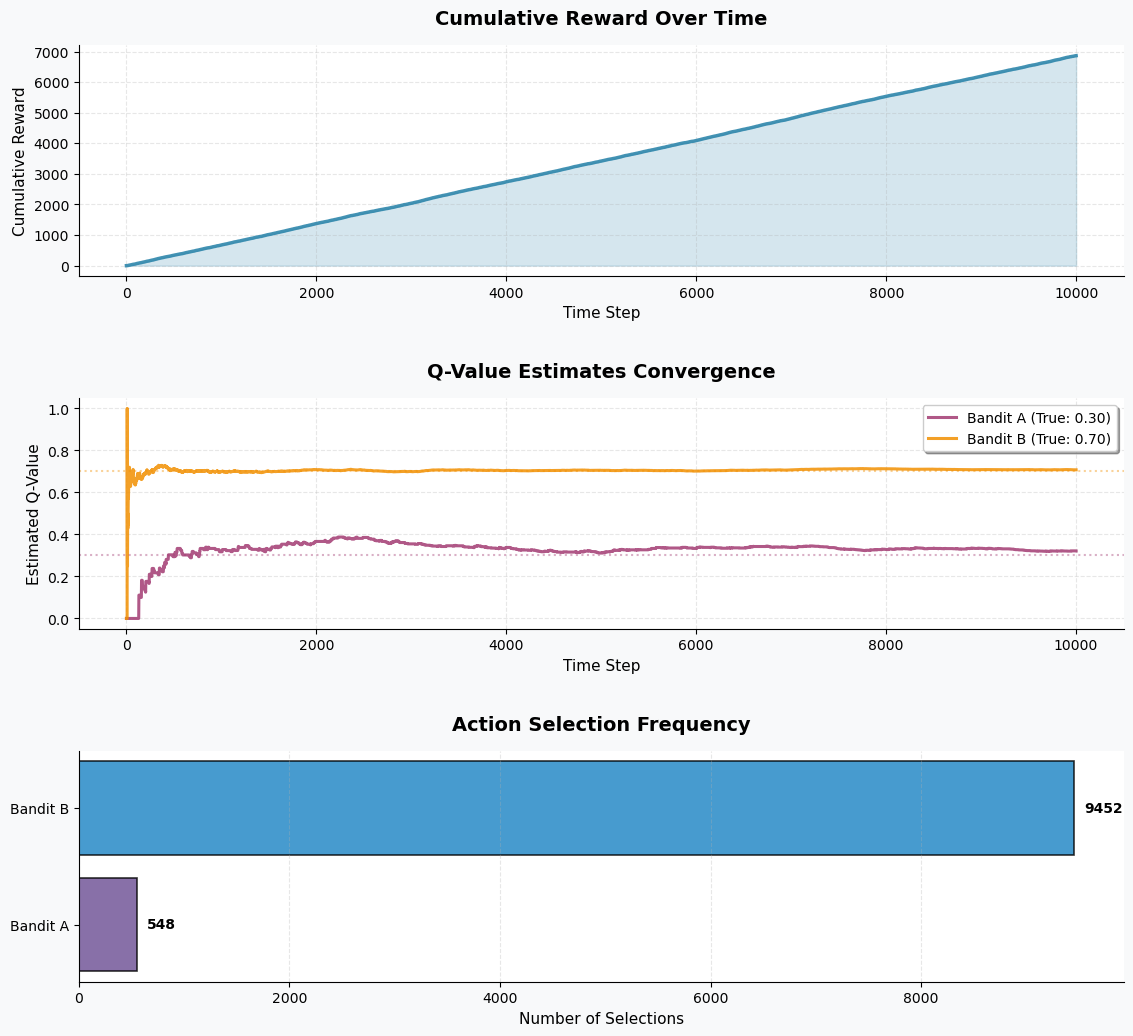

In [57]:
print("\nRunning binary bandit epsilon-greedy experiment (10k steps)...")
bandit_a = BernoulliBandit(prob_success=0.3)
bandit_b = BernoulliBandit(prob_success=0.7)
rewards, actions, q_history = epsilon_greedy_two_arm(bandit_a, bandit_b, epsilon=0.1, n_steps=10000, seed=0)
print(f"Binary bandit average reward: {np.mean(rewards):.4f}")
fig1 = plot_binary_results(rewards, actions, q_history, true_probs=[0.3, 0.7])
plt.show()

## Part 3: Non-Stationary 10-Armed Bandit

### Non-Stationary Bandit Class

A 10-armed bandit where all mean rewards undergo random walks, making this a challenging non-stationary problem.

**Key Challenge**: Traditional sample-average methods fail because past rewards become less relevant as true values drift over time.

In [58]:
class NonStationaryBandit:
    def __init__(self, n_arms: int = 10, initial_mean: float = 0.0, walk_std: float = 0.01):
        self.n_arms = int(n_arms)
        self.means = np.ones(self.n_arms) * float(initial_mean)
        self.walk_std = float(walk_std)

    def pull(self, action: int) -> float:
        action = int(action)
        reward = np.random.normal(self.means[action], 1.0)
        # random walk update for all means
        self.means += np.random.normal(0.0, self.walk_std, size=self.n_arms)
        return float(reward)

    def get_best_action(self) -> int:
        return int(np.argmax(self.means))

### Modified Epsilon-Greedy for Non-Stationary Problems

Uses a constant step-size parameter (α) instead of sample averaging to give more weight to recent rewards. This allows the algorithm to track non-stationary reward distributions.

**Key Modification**: Q(a) ← Q(a) + α[R - Q(a)] where α is a constant (typically 0.1)

In [59]:
def epsilon_greedy_tracking(bandit: NonStationaryBandit,
                           epsilon: float = 0.1,
                           alpha: float = 0.1,
                           n_steps: int = 10000,
                           seed: int = 0):
    np.random.seed(seed)
    random.seed(seed)
    Q = np.zeros(bandit.n_arms)
    rewards = np.empty(n_steps)
    optimal_actions = np.empty(n_steps, dtype=int)
    selected_actions = np.empty(n_steps, dtype=int)
    q_values_history = [Q.copy()]

    for t in range(n_steps):
        if np.random.random() < epsilon:
            action = np.random.randint(bandit.n_arms)
        else:
            action = int(np.argmax(Q))
        reward = bandit.pull(action)
        Q[action] += alpha * (reward - Q[action])
        rewards[t] = reward
        selected_actions[t] = action
        optimal_actions[t] = 1 if action == bandit.get_best_action() else 0
        q_values_history.append(Q.copy())

    return {
        'rewards': rewards,
        'optimal_actions': optimal_actions,
        'selected_actions': selected_actions,
        'q_history': np.vstack(q_values_history)
    }

### Plotting Function for Non-Stationary Bandit

Visualization showing average reward and optimal action selection percentage over time.

In [60]:
def plot_nonstationary_results(results, window=100):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    rewards = results['rewards']
    if len(rewards) >= window:
        avg_reward = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0].plot(avg_reward)
        axes[0].set_title(f"Average Reward (window={window})")
        axes[0].grid(True)
    else:
        axes[0].text(0.5, 0.5, "Not enough data for window", ha='center')

    opt = results['optimal_actions'].astype(float)
    if len(opt) >= window:
        opt_pct = np.convolve(opt, np.ones(window)/window, mode='valid') * 100
        axes[1].plot(opt_pct)
        axes[1].axhline(50, linestyle='--', alpha=0.5, label='Random baseline')
        axes[1].set_title("Optimal Action % (windowed)")
        axes[1].legend()
        axes[1].grid(True)
    else:
        axes[1].text(0.5, 0.5, "Not enough data for window", ha='center')

    plt.tight_layout()
    return fig

### Run Non-Stationary Bandit Experiment

Execute the non-stationary 10-armed bandit with modified epsilon-greedy algorithm.


Running 10-armed non-stationary bandit (10k steps) with modified epsilon-greedy...
Non-stationary bandit average reward: 0.7368
Optimal action selection (overall): 53.11%


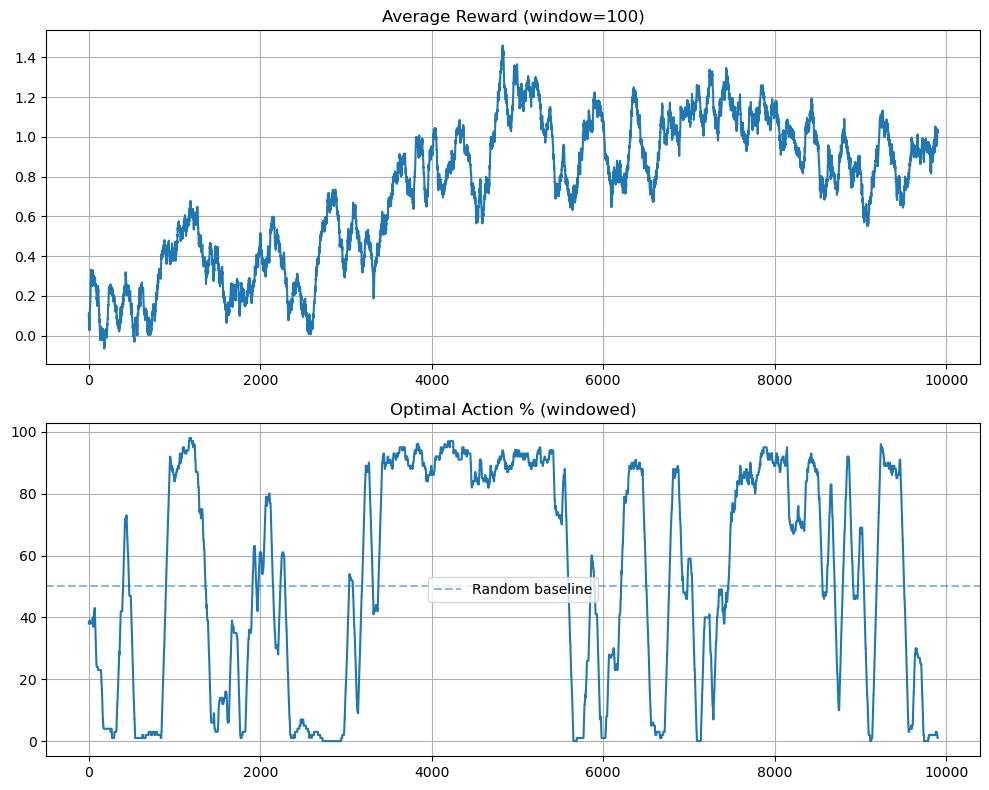


All tasks complete.


In [61]:
print("\nRunning 10-armed non-stationary bandit (10k steps) with modified epsilon-greedy...")
bandit_ns = NonStationaryBandit(n_arms=10, initial_mean=0.0, walk_std=0.01)
results_ns = epsilon_greedy_tracking(bandit_ns, epsilon=0.1, alpha=0.1, n_steps=10000, seed=1)
avg_reward_ns = np.mean(results_ns['rewards'])
opt_pct_ns = np.mean(results_ns['optimal_actions']) * 100
print(f"Non-stationary bandit average reward: {avg_reward_ns:.4f}")
print(f"Optimal action selection (overall): {opt_pct_ns:.2f}%")
fig2 = plot_nonstationary_results(results_ns, window=100)
plt.show()

print("\nAll tasks complete.")

## Summary

This notebook successfully implements:

1. **MENACE**: A reinforcement learning agent that learns Tic-Tac-Toe through a bead-based reward mechanism
2. **Binary Bandit**: Demonstrates epsilon-greedy algorithm on stationary stochastic rewards
3. **Non-Stationary Bandit**: Shows how constant step-size updates help track drifting reward distributions

**Key Insights:**
- MENACE learns through simple reinforcement without explicit state-value functions
- Epsilon-greedy balances exploration vs exploitation effectively
- Non-stationary problems require exponential recency-weighted averaging (constant α) rather than sample averaging